# Credit Card Fraud - Model Tuning

Machine Learning models tuning is a type of optimization problem. We have a set of hyperparameters and we aim to find the right combination of their values which can help us to find either the minimum (eg. loss) or the maximum (eg. accuracy) of a function.

Below, is shown a really simple example of how to find the minimum of a function using Scipy. 

In this Notebook, I will walk you through different techniques commonly used in Machine Learning to optimise Hyperparameters selection to improve accuracy results.

**Table of Contents:**
1. Manual Search
2. Random Search
3. Grid Search
4. Automated Hyperparameter Tuning (Bayesian Optimization, Genetic Algorithms)
5. Artificial Neural Networks (ANNs) Tuning

Global minima (-20-15) at: 0.013750000000006354
Local minimum (5-15) at: 12.078382194916786


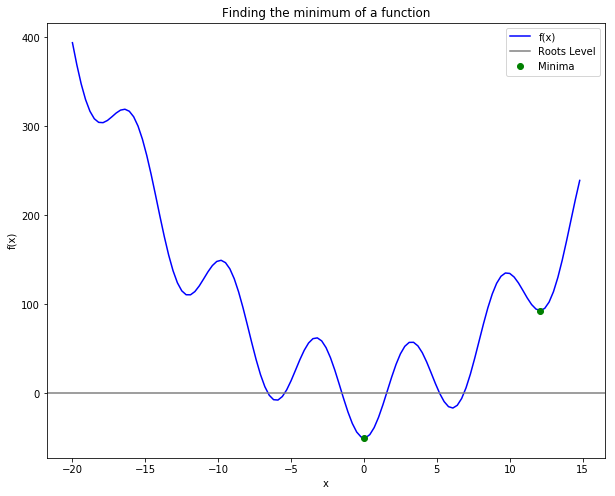

In [1]:
# Source: https://scipy-lectures.org/intro/scipy/auto_examples/plot_optimize_example2.html
import numpy as np 
import matplotlib.pyplot as plt
from scipy import optimize

# Creating a function to examine
x = np.arange(-20, 15, 0.3)
def f(x):
    return x**2 - (5*x)/7 - 50*np.cos(x)

# Global optimization
grid = (-20, 15, 0.3)
xmin_global = optimize.brute(f, (grid, ))
print("Global minima (-20-15) at: {}".format(float(xmin_global)))

# Constrained optimization
xmin_local = optimize.fminbound(f, 5, 15)
print("Local minimum (5-15) at: {}".format(xmin_local))

# Plotting the function
fig = plt.figure(figsize=(10, 8))
plt.plot(x, f(x), 'b', label="f(x)")

# Plotting horizontal line where possible roots can be found 
plt.axhline(0, color='gray', label="Roots Level")

# Plotting the function minima
xmins = np.array([xmin_global[0], xmin_local])
plt.plot(xmins, f(xmins), 'go', label="Minima")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Finding the minimum of a function")
plt.legend(loc='best')
plt.show()

A machine learning model can be composed by two different types of parameters:
- Hyperparamters are all the parameters which can be arbitrarely set by the user before starting training (eg. number of estimators in Random Forest). 
- Model parameters are instead learned during the model training (eg. weights in Neural Networks, Linear Regression).

The model parameters define how to use input data to get a desired output, while the hyperparameters determine how our model is structured in the first place. 

This can be particularly important when comparing how different Machine Learning models performs on a dataset. In fact, I would be unfair for example to compare an SVM model with the best hyperparameters against a Random Forest model with has not been optimized.

I will now walk you through a practical example using Kaggle Credit Card Fraud Dataset. In this case, I decided to use just a subset of the dataset, in order to speed up training times and make sure to achieve a perfect balance between the two different classes. Additionally, just a limited amount of features will be used in order to make the optimization tasks more challenging.

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


In [3]:
df = pd.read_csv("../input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(df.shape)
print(df.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [5]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
Time,0.0
V16,0.0
Amount,0.0
V28,0.0
V27,0.0
V26,0.0
V25,0.0
V24,0.0
V23,0.0
V22,0.0


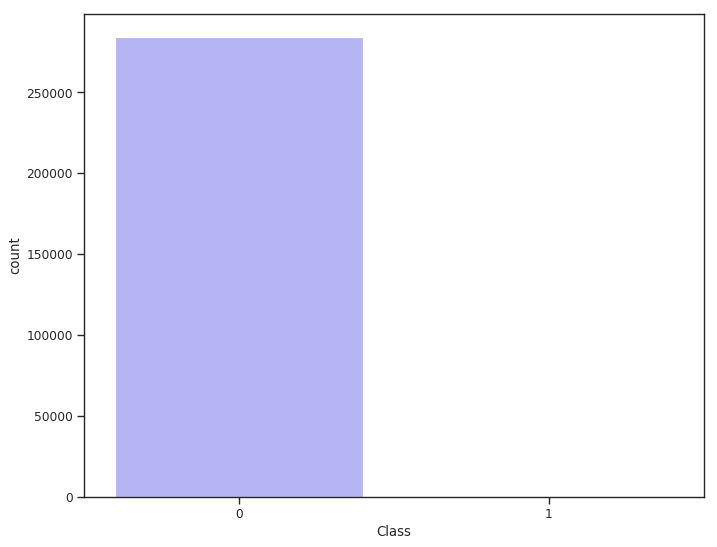

In [6]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

sns.set(style="ticks")
f = sns.countplot(x="Class", data=df, palette="bwr")
plt.show()

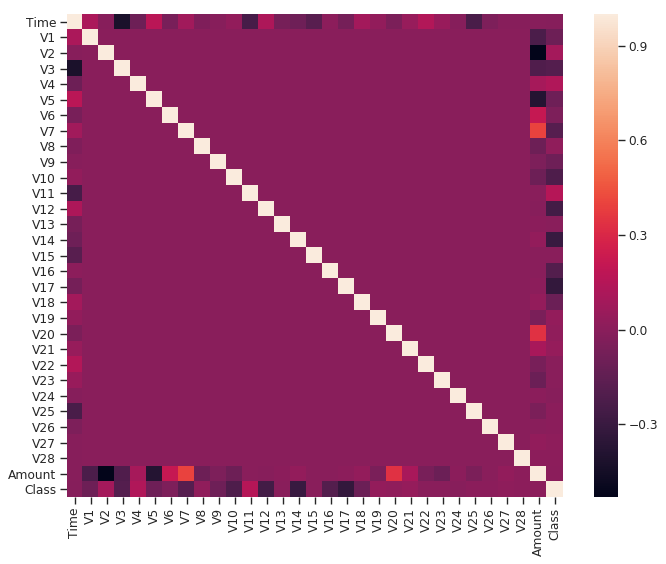

In [7]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

corr=df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [8]:
df2 = df[df.Class == 1][0:400]
print(df2.shape)
df3 = df[df.Class == 0][0:400]
print(df3.shape)

df = df2.append(df3, ignore_index=True)
#df4.head()
df.shape

(400, 31)
(400, 31)


(800, 31)

In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


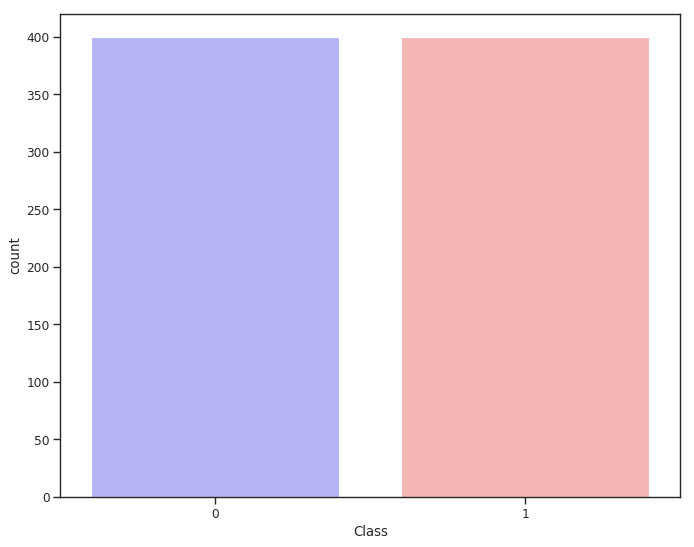

In [10]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

sns.set(style="ticks")
f = sns.countplot(x="Class", data=df, palette="bwr")
plt.show()

In [11]:
X = df.drop(['Class'], axis = 1).values
Y = df['Class']

X = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

In [12]:
model = RandomForestClassifier(n_estimators=300).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))

[[116   0]
 [  0 124]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       124

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



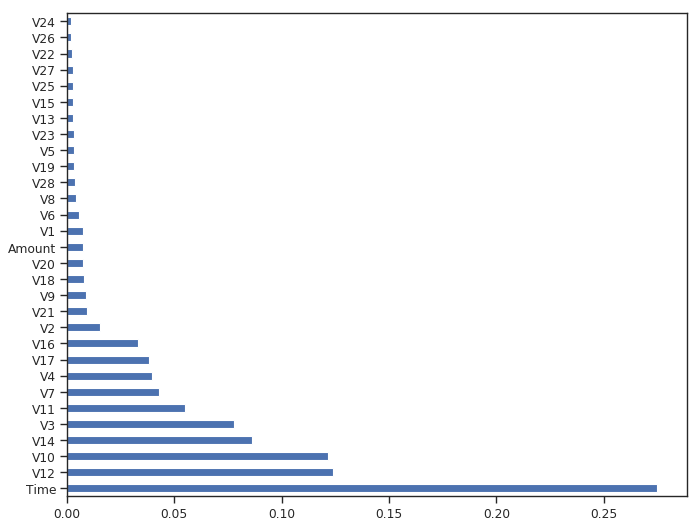

In [13]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

feat_importances = pd.Series(model.feature_importances_, index=df.drop(df[['Class']], 
                                                                       axis=1).columns)
feat_importances.nlargest(30).plot(kind='barh')

In [14]:
df[['V17', 'V9', 'V6', 'V12','Class']].head()

,V17,V9,V6,V12,Class
0,-2.830056,-2.770089,-1.426545,-2.899907,1
1,0.599717,-0.270953,-1.064823,-0.503141,1
2,-4.781831,-0.238253,-0.075788,-6.560124,1
3,-12.598419,-0.247768,-1.706536,-10.912819,1
4,6.739384,-1.282858,-1.357746,-4.609628,1


In [15]:
X = df[['V17', 'V9', 'V6', 'V12']]
Y = df['Class']

X = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

In [16]:
model = RandomForestClassifier(random_state= 101).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc1 = accuracy_score(Y_Test,predictionforest)

[[110   6]
 [  6 118]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       116
           1       0.95      0.95      0.95       124

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Manual Search

When using Manual Search, we choose some model hyperparameters based on our judgment/experience. We then train the model, evaluate its accuracy and start the process again. This loop is repeated until a satisficatory accuracy is scored.

The main parameters used by a Random Forest Classifier are:
- criterion = the function used to evaluate the quality of a split.
- max_depth = maximum number of levels allowed in each tree.
- max_features = maximum number of features considered when splitting a node.
- min_samples_leaf = minimum number of samples which can be stored in a tree leaf.
- min_samples_split = minimum number of samples necessary in a node to cause node splitting.
- n_estimators = number of trees in the ensamble.

In [17]:
model = RandomForestClassifier(n_estimators=10, random_state= 101).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc2 = accuracy_score(Y_Test,predictionforest)

[[110   6]
 [  6 118]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       116
           1       0.95      0.95      0.95       124

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



In [18]:
model = RandomForestClassifier(n_estimators= 200, max_features = "log2", min_samples_leaf = 20,
                               random_state= 101).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))

[[114   2]
 [ 13 111]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       116
           1       0.98      0.90      0.94       124

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240



## Random Search

In Random Search, we create a grid of hyperparameters and train/test our model on just some random combination of these hyperparameters.

#### Simple Random Search with Data Visualization

(This same data visualization analysis can be easily repeated using Grid Search and changing the appropriate parameters)

In [19]:
from sklearn.model_selection import RandomizedSearchCV

random_search = {
               'max_features': ['auto', 'sqrt','log2', None],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

print(random_search)

{'max_features': ['auto', 'sqrt', 'log2', None], 'n_estimators': [151, 267, 384, 500, 617, 733, 850, 966, 1083, 1200]}


In this example, I additionally decided to perform Cross-Validation on the training set. When performing Machine Learning tasks, we generally divide our dataset in training and test sets. This is done so that to test our model after having trained it to check it's performances when working with unseen data. When using Cross-Validation, we divide our training set in N other partitions to make sure our model is not overfitting our data. 

One of the most common used Cross-Validation methods is K-Fold Validation. In K-Fold, we divide our dataset in N partitions and then iteratively train our model using N-1 partitions and test it with the left-over partition (at each iteration we change the left-over partition). Once having trained N times our model we then average the training results obtained in each iteration to obtain our overall training performance results.

![](http://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png)

Using Cross-Validation when implementing Hyperparameters optimization can be really important. In this way, we might avoid using some Hyperparameters which works really good on the training data but not so good with the test data. 

In [20]:
clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_Train,Y_Train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 40 is smaller than n_iter=80. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.4min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

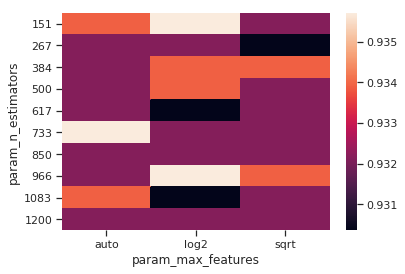

In [21]:
table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', columns='param_max_features')
     
sns.heatmap(table)

Chaning evaluation metric from Accuracy to Area Under the Curve (AUC).

In [22]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

def auc_metric(true, pred):
    auc_score = roc_auc_score(pred, true)    
    return auc_score

metric = make_scorer(auc_metric, greater_is_better=True)

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search,  
                               n_iter = 80, cv = 4, verbose= 5, random_state= 101, 
                               n_jobs = -1, scoring = metric)

model.fit(X_Train,Y_Train)

n_estimators, max_features = list(np.linspace(151, 1200, 10, dtype = int)), ['auto', 'sqrt','log2', None]

res = model.cv_results_['mean_test_score'].reshape(len(n_estimators), len(max_features))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 40 is smaller than n_iter=80. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.3min finished


Text(0.5, 1.0, 'Using Area Under the Curve instead of Accuracy as evaluation metric')

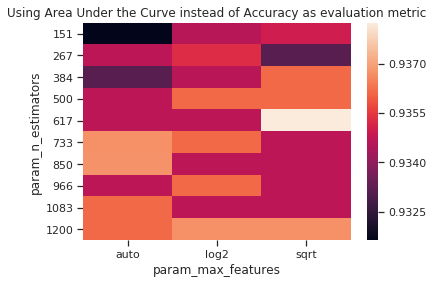

In [23]:
table = pd.pivot_table(pd.DataFrame(model.cv_results_), 
                       values='mean_test_score', index='param_n_estimators', columns='param_max_features')
     
sns.heatmap(table)
plt.title("Using Area Under the Curve instead of Accuracy as evaluation metric")

Visualizing how cross validation accuracy changes varying the number of estimators and maximum features.

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


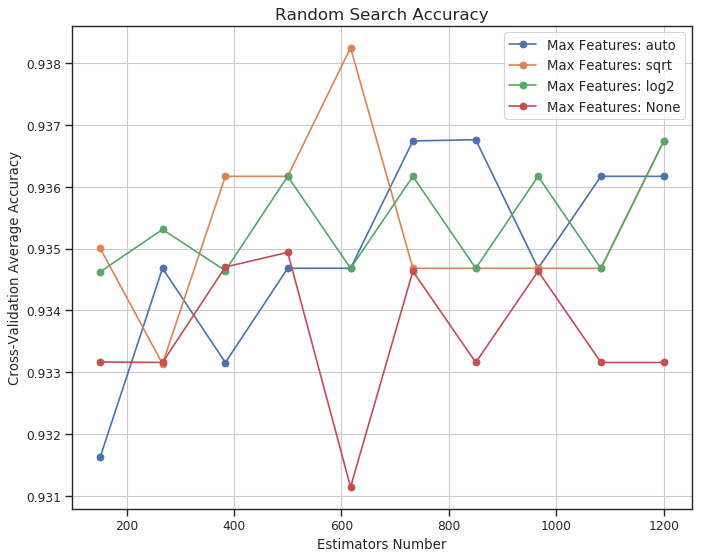

In [24]:
def search_plot(grid, param1, param2, name1, name2):

    grid = grid.cv_results_
    scores_mean = grid['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(param2),len(param1))

    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    for idx, val in enumerate(param2):
        plt.plot(param1, scores_mean[idx,:], '-o', label= name2 + ': ' + str(val))

    plt.title("Random Search Accuracy", fontsize=15)
    plt.xlabel(name1, fontsize=12)
    plt.ylabel('Cross-Validation Average Accuracy', fontsize=12)
    plt.legend(loc="best", fontsize=12)
    plt.grid('on')
    
search_plot(model, n_estimators, max_features, 'Estimators Number', 'Max Features')

Visualizing how validation accuracy changes varying the estimators number (incorporating uncertainty in accuracy).

In [25]:
# From: https://matthewbilyeu.com/blog/2019-02-05/validation-curve-plot-from-gridsearchcv-results
import numbers

def plot_grid_search_validation_curve(grid, param_to_vary, title='Validation Accuracy Curve', ylim=None,
                                      xlim=None, log=None):

    df_cv_results = pd.DataFrame(grid.cv_results_)
    valid_scores_mean = df_cv_results['mean_test_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_distributions[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    valid_scores_mean = valid_scores_mean[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()
    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)
    if (not (xlim is None)):
        plt.xlim(*xlim)
        
    lw = 2
    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
    if (not isinstance(param_range[0], numbers.Number)):
        param_range = [str(x) for x in param_range]
    plot_fn(param_range, valid_scores_mean, label='Cross-Validation Accuracy',
            color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)
    plt.legend(loc='lower right')
    plt.show()

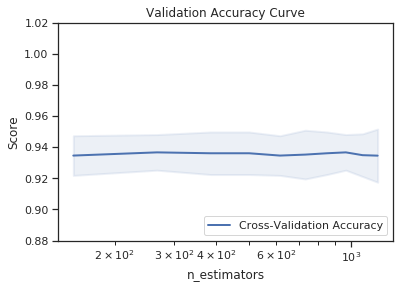

In [26]:
plot_grid_search_validation_curve(model, 'n_estimators', log=True, ylim=(.88, 1.02))

#### Complete Random Search

In [27]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_Train,Y_Train)

model.best_params_

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.7min finished


{'n_estimators': 500,
 'min_samples_split': 7,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 142,
 'criterion': 'entropy'}

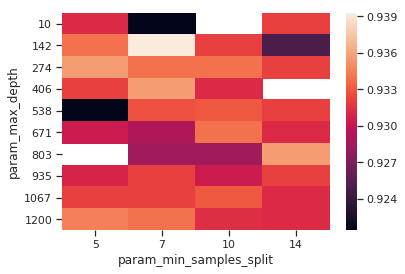

In [28]:
table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')
     
sns.heatmap(table)

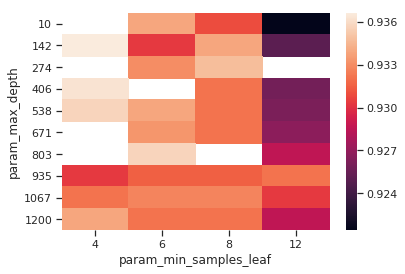

In [29]:
table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_samples_leaf')
     
sns.heatmap(table)

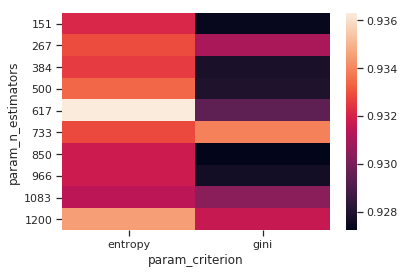

In [30]:
table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', columns='param_criterion')
     
sns.heatmap(table)

In [31]:
predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc3 = accuracy_score(Y_Test,predictionforest)

[[115   1]
 [  6 118]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       116
           1       0.99      0.95      0.97       124

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



#### Plotly Interactive Visualization

This interactive data visualization was realised following Xoel López Barata
guide: https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

In [32]:
df = pd.DataFrame.from_dict(model.cv_results_)
df['param_min_samples_leaf'] = df['param_min_samples_leaf'].astype(float)
df['param_n_estimators'] = df['param_n_estimators'].astype(float)
df['param_min_samples_split'] = df['param_min_samples_split'].astype(float)
df['mean_fit_time'] = df['mean_fit_time'].astype(float)
df['mean_test_score'] = df['mean_test_score'].astype(float)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.707879,0.005801,0.037025,0.001669,267.0,14.0,4.0,log2,1200,gini,"{'n_estimators': 267, 'min_samples_split': 14,...",0.928571,0.942857,0.914286,0.928571,0.928571,0.010102,61
1,2.803975,0.018831,0.124854,0.005802,966.0,10.0,8.0,sqrt,274,entropy,"{'n_estimators': 966, 'min_samples_split': 10,...",0.921429,0.957143,0.921429,0.935714,0.933929,0.014617,14
2,0.790679,0.019953,0.037929,0.002827,267.0,5.0,8.0,auto,274,entropy,"{'n_estimators': 267, 'min_samples_split': 5, ...",0.928571,0.957143,0.921429,0.935714,0.935714,0.013363,6
3,2.288275,0.035759,0.114665,0.004402,850.0,5.0,4.0,log2,142,gini,"{'n_estimators': 850, 'min_samples_split': 5, ...",0.928571,0.950000,0.928571,0.928571,0.933929,0.009279,14
4,2.463521,0.052918,0.089374,0.005642,733.0,7.0,8.0,None,1067,entropy,"{'n_estimators': 733, 'min_samples_split': 7, ...",0.907143,0.957143,0.928571,0.928571,0.930357,0.017768,51


In [33]:
text = list(
    zip(
        'max_features: ' + df['param_max_features'].apply(str),
        'n_estimators: ' + df['param_n_estimators'].apply(str),
        'min_samples_split: ' + df['param_min_samples_split'].apply(str),
        'Test score: ' + df['mean_test_score'].round(3).apply(str),
        'Training time: ' + (df['mean_fit_time'] % 60).round(3).apply(str) + ' s',
    )
)

hower_text = ['<br>'.join(i) for i in text]
df['hover_text'] = hower_text

In [34]:
import plotly.graph_objs as go
from ipywidgets import interactive, VBox, widgets, interact

trace = go.Scatter3d(
    x= df['param_n_estimators'],
    y= df['param_min_samples_leaf'],
    z= df['param_min_samples_split'],
    mode='markers', 
    marker=dict(
        size= 7,
        color= df['mean_test_score'],
        colorscale= 'Jet',
        colorbar= dict(title = 'Cross-Validation Accuracy')
    ),
    text= df['hover_text'],
    hoverinfo= 'text'
)

data = [trace]
layout = go.Layout(
    scene = dict(
        camera = dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=2, y=2, z=1.25)
        ),
        xaxis = dict(
            title='n_estimators',
            range=[min(df['param_n_estimators']), max(df['param_n_estimators'])]
        ),
        yaxis = dict(
            title='min_leaf',
            type='log'
        ),
        zaxis = dict(
            title='min_split',
            type='log'

        ),
    ),
)

fig = go.FigureWidget(data,layout)

xmin, xmax = fig['layout']['scene']['xaxis']['range']

slider = widgets.FloatRangeSlider(
    value= fig.layout.scene.xaxis.range,
    min= xmin,
    max= xmax,
    step= (xmax - xmin) / 50,
    description= 'n_estimators')
slider.layout.width = '700px'

def update_range(y):
    fig.layout.scene.xaxis.range = [y[0], y[1]]
    
box = VBox((interactive(update_range, y=slider), fig))
box.layout.align_items = 'center'
box

In [35]:
listn = list(set(df['param_n_estimators']))
listn.sort()

data = []
for i, n in enumerate(listn):
    filtered_df = df[df.param_n_estimators==n]
    trace = [
        go.Scatter3d(
    x= filtered_df['param_n_estimators'],
    y= filtered_df['param_min_samples_leaf'],
    z= filtered_df['param_min_samples_split'],
    mode='markers', 
    marker=dict(
        size= 7,
        color= df['mean_test_score'],
        colorscale= 'Jet',
        colorbar= dict(title = 'Cross-Validation Accuracy')
    ),
    text= filtered_df['hover_text'],
    hoverinfo= 'text'
)
    ]
    
    data.append(trace[0])
    data[i].showlegend=False

steps = []
for i, n in enumerate(listn):
    step = dict(
        method='restyle',
        args = ['visible', [False] * len(data) * 2]
    )
    step['args'][1][i] = True # toggle i'th traces to 'visible'
    step['label'] = str(n)
    steps.append(step)



sliders = [dict(
    active = 4,
    currentvalue = {"prefix": "n_estimators: "},
    pad = {"t": 10, 'b': 20},
    steps = steps,
    len=.5,
    xanchor = 'center',
    x = 0.5
)]

layout = go.Layout(
    title = "Cross-Validation Accuracy Varying Hyperparameters",
    width=700,
    height=600,
    sliders = sliders,
    scene = dict(
        camera = dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=2, y=2, z=1.25)
        ),
        xaxis = dict(
            title='n_estimators',
        ),
        yaxis = dict(
            title='min_leaf',
            type='log'
        ),
        zaxis = dict(
            title='min_split',
            type='log'

        ),
    ),
)


fig = go.FigureWidget(data,layout)
fig

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': array([0.92857143, 0.93392…

In [36]:
data = []
for i, n in enumerate(listn):
    filtered_df = df[df.param_n_estimators==n]
    trace = [
        go.Scatter3d(
    x= filtered_df['param_n_estimators'],
    y= filtered_df['param_min_samples_leaf'],
    z= filtered_df['mean_test_score'],
    mode='markers', 
    marker=dict(
        size= 7,
        color= df['mean_test_score'],
        colorscale= 'Jet',
    ),
    text= filtered_df['hover_text'],
    hoverinfo= 'text'
)
    ]
    
    data.append(trace[0])
    data[i].showlegend=False

steps = []
for i, n in enumerate(listn):
    step = dict(
        method='restyle',
        args = ['visible', [False] * len(data) * 2]
    )
    step['args'][1][i] = True # toggle i'th traces to 'visible'
    step['label'] = str(n)
    steps.append(step)



sliders = [dict(
    active = 4,
    currentvalue = {"prefix": "n_estimators: "},
    pad = {"t": 10, 'b': 20},
    steps = steps,
    len=.5,
    xanchor = 'center',
    x = 0.5
)]

layout = go.Layout(
    title = "Cross-Validation Accuracy Varying n_estimators and min_leaf",
    width=700,
    height=600,
    sliders = sliders,
    scene = dict(
        camera = dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=2, y=2, z=1.25)
        ),
        xaxis = dict(
            title='n_estimators',
        ),
        yaxis = dict(
            title='min_leaf',
            type='log'
        ),
        zaxis = dict(
            title='accuracy',
            type='log'

        ),
    ),
)

fig = go.FigureWidget(data,layout)
fig

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': array([0.92857143, 0.93392…

## Grid Search

In Grid Search, we set up a grid of hyperparameters and train/test our model on each of the possible combinations. 


In order to choose the parameters to use in Grid Search, we can try to run first Random Search to get an understanding of which values might perform best on the considered dataset.

In [37]:
from sklearn.model_selection import GridSearchCV

grid_search = {
    'criterion': [model.best_params_['criterion']],
    'max_depth': [model.best_params_['max_depth']],
    'max_features': [model.best_params_['max_features']],
    'min_samples_leaf': [model.best_params_['min_samples_leaf'] - 2, 
                         model.best_params_['min_samples_leaf'], 
                         model.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [model.best_params_['min_samples_split'] - 3, 
                          model.best_params_['min_samples_split'], 
                          model.best_params_['min_samples_split'] + 3],
    'n_estimators': [model.best_params_['n_estimators'] - 150, model.best_params_['n_estimators'] - 100, 
                     model.best_params_['n_estimators'], 
                     model.best_params_['n_estimators'] + 100, model.best_params_['n_estimators'] + 150]
}

print(grid_search)

{'criterion': ['entropy'], 'max_depth': [142], 'max_features': ['log2'], 'min_samples_leaf': [2, 4, 6], 'min_samples_split': [4, 7, 10], 'n_estimators': [350, 400, 500, 600, 650]}


In [38]:
clf = RandomForestClassifier()
model = GridSearchCV(estimator = clf, param_grid = grid_search, 
                               cv = 4, verbose= 5, n_jobs = -1)
model.fit(X_Train,Y_Train)

Fitting 4 folds for each of 45 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [39]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 142,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 500}

In [40]:
predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc4 = accuracy_score(Y_Test,predictionforest)

[[115   1]
 [  7 117]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       116
           1       0.99      0.94      0.97       124

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



Grid Search is slower compared to Random Search but can be more effective because it can go through the whole search space. Instead, Random Search can be faster fast, but might miss some important points in the search space.

## Automated Hyperparameter Tuning

Using Automated Hyperparameter Tuning, the model hyperparameters to try are identified using techniques such as: Bayesian Optimization, Gradient Descent and Evolutionary Algorithms. 

### Bayesian Optimization

Hyperopt is a Python library used to optimize Machine Learning models using Bayesian Optimization. Bayesian optimization uses probability to find the minimum of a function. The final aim is to find the input value to a function which can gives us the lowest possible output value. <br>

Baysian optimization has been proved to be more efficient than random, grid or manual search. Bayesian Optimization can therefore lead to better performance in the testing phase and reduced optimization time.

In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin. <br>

- Objective Function = defines the loss function to minimize.
- Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
- Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration. 

Additionally, can also be defined in fmin the maximum number of evaluations to perform.

Bayesian Optimization can reduce the number of search iterations by choosing the input values bearing in mind the past outcomes. In this way, we can concentrate our search from the beginning on values which are closer to our desired output.

In [41]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score

In [42]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

In [43]:
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_Train, Y_Train, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

We can now run our Bayesian Optimizer using the fmin() function. A Trials() object is first created to make possible later to visualize later what was going on while the fmin() function was running (eg. how the loss function was changing and how to used Hyperparameters were changing).

In [44]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [03:07<00:00,  2.02s/it, best loss: -0.9339285714285713]


{'criterion': 1,
 'max_depth': 120.0,
 'max_features': 2,
 'min_samples_leaf': 0.0006380325074247448,
 'min_samples_split': 0.06603114636418073,
 'n_estimators': 1}

0 criterion
1 max_depth
2 max_features
3 min_samples_leaf
4 min_samples_split
5 n_estimators


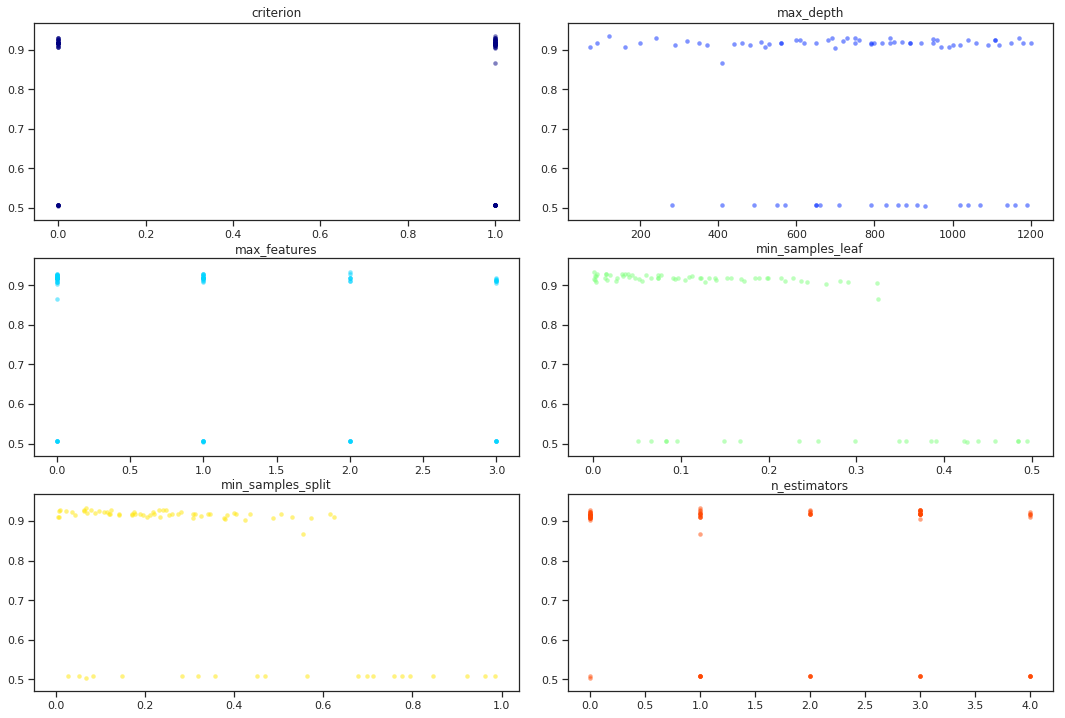

In [45]:
# From: https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce
parameters = ['criterion', 'max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split',
              'n_estimators']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print(i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i//2,i%2].set_title(val)

In [46]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

print(crit[best['criterion']])
print(feat[best['max_features']])
print(est[best['n_estimators']])

gini
log2
50


In [47]:
trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_Train,Y_Train)
predictionforest = trainedforest.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc5 = accuracy_score(Y_Test,predictionforest)

[[114   2]
 [ 11 113]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       116
           1       0.98      0.91      0.95       124

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



### Genetic Algorithms

Genetic Algorithms tries to apply natural selection mechanisms to Machine Learning contexts. 

Let's immagine we create a population of N Machine Learning models with some predifined Hyperparameters. We can then calculate the accuracy of each model and decide to keep just half of the models (the ones that performs best). We can now generate some offsprings having similar Hyperparameters to the ones of the best models so that go get again a population of N models. At this point we can again caltulate the accuracy of each model and repeate the cycle for a defined number of generations. In this way, just the best models will survive at the end of the process.

In [48]:
parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

In [49]:
from tpot import TPOTClassifier
from deap.gp import Primitive


tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(X_Train,Y_Train)

Generation 1 - Current best internal CV score: 0.9392857142857143
Generation 2 - Current best internal CV score: 0.9392857142857143
Generation 3 - Current best internal CV score: 0.9392857142857143
Generation 4 - Current best internal CV score: 0.9392857142857143
Generation 5 - Current best internal CV score: 0.9392857142857143

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=entropy, max_depth=406, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=617)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [10,
                                                                                      142,
                                                                                      274,
                                                                                      406,
                                                                                      538,
                                                                                      671,
                                                                                      803,
                                                                                      935,
                                                                                 

In [50]:
acc6 = tpot_classifier.score(X_Test, Y_Test)
print(acc6)

0.9708333333333333


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning:

The default validate=True will be replaced by validate=False in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning:

The default validate=True will be replaced by validate=False in 0.22.



In [51]:
# https://medium.com/cindicator/genetic-algorithms-and-hyperparameters-weekend-of-a-data-scientist-8f069669015e
args = {}
for arg in tpot_classifier._optimized_pipeline:
    if type(arg) != Primitive:
        try:
            if arg.value.split('__')[1].split('=')[0] in ['criterion', 'max_depth', 
                                                          'max_features', 'min_samples_leaf', 
                                                          'min_samples_split',
                                                          'n_estimators']:
                args[arg.value.split('__')[1].split('=')[0]] = int(arg.value.split('__')[1].split('=')[1])
            else:
                args[arg.value.split('__')[1].split('=')[0]] = float(arg.value.split('__')[1].split('=')[1])
        except:
            pass
params = args

In [52]:
params

{'max_depth': 406,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 617}

In [53]:
model = RandomForestClassifier( max_depth = params['max_depth'],
                             min_samples_leaf = params['min_samples_leaf'],
                             min_samples_split = params['min_samples_split'],
                             n_estimators = params['n_estimators'], 
                             )
model.fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
accuracy_score(Y_Test,predictionforest)

[[115   1]
 [  7 117]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       116
           1       0.99      0.94      0.97       124

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



0.9666666666666667

## Artificial Neural Networks (ANNs) Tuning

Using KerasClassifier wrapper, it is possible to apply Grid Search and Random Search for Deep Learning models in the same way it was done when using Sklearn Machine Learning models. More examples are available here:
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

def DL_Model(activation= 'linear', neurons= 5, optimizer='Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim= 4, activation= activation))
    model.add(Dense(neurons, activation= activation))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

# Definying grid parameters
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']
neurons = [5, 10, 15, 25, 35, 50]
optimizer = ['SGD', 'Adam', 'Adamax']
param_grid = dict(activation = activation, neurons = neurons, optimizer = optimizer)

clf = KerasClassifier(build_fn= DL_Model, epochs= 80, batch_size=40, verbose= 0)

model = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1)
model.fit(X_Train,Y_Train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), model.best_params_))
acc = model.cv_results_['mean_test_score']
hyper = model.cv_results_['params']

for mean, param in zip(acc, hyper):
    print("Overall accuracy of {} % using: {}".format(round(mean, 3), param))

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1

Max Accuracy Registred: 0.932 using {'activation': 'relu', 'neurons': 35, 'optimizer': 'Adam'}
Overall accuracy of 0.488 % using: {'activation': 'softmax', 'neurons': 5, 'optimizer': 'SGD'}
Overall accuracy of 0.887 % using: {'activation': 'softmax', 'neurons': 5, 'optimizer': 'Adam'}
Overall accuracy of 0.891 % using: {'activation': 'softmax', 'neurons': 5, 'optimizer': 'Adamax'}
Overall accuracy of 0.455 % using: {'activation': 'softmax', 'neurons': 10, 'optimizer': 'SGD'}
Overall accuracy of 0.887 % using: {'activation': 'softmax', 'neurons': 10, 'optimizer': 'Adam'}
Overall accuracy of 0.879 % using: {'activation': 'softmax', 'neurons': 10, 'optimizer': 'Adamax'}
Overall accuracy of 0.454 % using: {'activation': 'softmax', 'neurons': 15, 'optimizer': 'SGD'}
Overall accuracy of 0.887 % using: {'activation': 'softmax', 'neurons': 15, 'optimizer': 'Adam'}
Overall accuracy of 0.882 % using: {'activation': 'softmax', 'neurons': 15, 'optimizer': 'Adamax'}
Overall accuracy of 0.459 % usin

In [55]:
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc7 = accuracy_score(Y_Test,predictionforest)

[[115   1]
 [  8 116]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       116
           1       0.99      0.94      0.96       124

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



## Comparison

In [56]:
print('Base Accuracy vs Manual Search {:0.4f}%.'.format( 100 * (acc2 - acc1) / acc1))
print('Base Accuracy vs Random Search {:0.4f}%.'.format( 100 * (acc3 - acc1) / acc1))
print('Base Accuracy vs Grid Search {:0.4f}%.'.format( 100 * (acc4 - acc1) / acc1))
print('Base Accuracy vs Bayesian Optimization Accuracy {:0.4f}%.'.format( 100 * (acc5 - acc1) / acc1))
print('Base Accuracy vs Evolutionary Algorithms {:0.4f}%.'.format( 100 * (acc6 - acc1) / acc1))
print('Base Accuracy vs Optimized ANN {:0.4f}%.'.format( 100 * (acc7 - acc1) / acc1))

Base Accuracy vs Manual Search 0.0000%.
Base Accuracy vs Random Search 2.1930%.
Base Accuracy vs Grid Search 1.7544%.
Base Accuracy vs Bayesian Optimization Accuracy -0.4386%.
Base Accuracy vs Evolutionary Algorithms 2.1930%.
Base Accuracy vs Optimized ANN 1.3158%.
